# Exploratory analysis of youtube trending videos

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random
from datetime import time
%matplotlib inline

random.seed(100)

datadir = './data/'

data_raw = pd.read_csv(datadir + 'USvideos.csv')
data_raw.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


# Preprocessing

Convert times to date

In [66]:
data_raw['publish_time'] = pd.to_datetime(data_raw.publish_time)

Convert the publish time to which day of the week it was published on

In [67]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_raw['trending_date'] = '20' + data_raw['trending_date'] 
data_raw['trending_date'] = pd.to_datetime(data_raw.trending_date, format='%Y.%d.%m').dt.dayofweek
data_raw['trending_date'] = data_raw['trending_date'].apply(lambda x: weekday_labels[int(x)])

In [68]:
data_raw.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,Tuesday,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,Tuesday,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,Tuesday,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,Tuesday,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,Tuesday,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


Convert the video category ids to actual readable text

Our tidy data will be in a variable named tidy. We removed ratings, comments, thumbnail_link from out columns. After that, we will start  by binning the publish_time column into Late-night (12am-7am), morning(7am-11am), noon(11am-12pm), afternoon (12pm-7pm), Night(7pm-12am

In [69]:
tidy = data_raw.copy(deep=True)
del tidy['ratings_disabled']
del tidy['comments_disabled']
del tidy['thumbnail_link']
del tidy['video_error_or_removed']

In [70]:
periods = {'Morning(5a-11a)': [time(5), time(11)], 'Noon(11a-12p)': [time(11), time(12)], 
           'Afternoon(12p-7p)': [time(12), time(19)],
          'Night(7p-12a)': [time(19), time(23)], 'Overnight(12a-5a)': [time(0), time(5)]}

In [71]:
def bin_values(x, labels=periods):
    for k, v in labels.items():
        if x.hour >= v[0].hour and x.hour < v[1].hour:
            return k
    return 'Unknown_period'
            

In [72]:
tidy['publish_time'] = tidy['publish_time'].apply(bin_values)

We will update the video categories with their representative name

In [73]:
video_categories = pd.read_csv(datadir + 'youtube_video_categories.csv', names=['id', 'title'])

In [74]:
video_categories.head()

,id,title
0,2,Autos & Vehicles
1,1,Film & Animation
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [75]:
cat_values = []
for index, video_id in enumerate(tidy['category_id']):
    cat = video_categories[ video_categories['id'] == video_id]['title'].iloc[0]
    cat_values.append(cat)

tidy['category_names'] = pd.Series(cat_values, index=[i for i in range(0, len(tidy))])

In [76]:
tidy.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description,category_names
0,2kyS6SvSYSE,Tuesday,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,Afternoon(12p-7p),SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,Tuesday,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,Morning(5a-11a),"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,Tuesday,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,Night(7p-12a),"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,Tuesday,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,Noon(11a-12p),"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,Tuesday,I Dare You: GOING BALD!?,nigahiga,24,Afternoon(12p-7p),"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,I know it's been a while since we did this sho...,Entertainment


## Correlation Analysis

Let's analyze the correlation between the variables

In [77]:
tidy[['category_id', 'views', 'likes', 'dislikes', 'comment_count']].corr()

,category_id,views,likes,dislikes,comment_count
category_id,1.000000,-0.163287,-0.158824,-0.114962,-0.096763
views,-0.163287,1.000000,0.846959,0.872078,0.567767
likes,-0.158824,0.846959,1.000000,0.776148,0.852084
dislikes,-0.114962,0.872078,0.776148,1.000000,0.562060
comment_count,-0.096763,0.567767,0.852084,0.562060,1.000000


We can see that there is high correlation between views, likes, dislikes, and comment_count. Same for the comment_count-views vs views-dislikes Let's apply a t-test and look at the p-values to check if these correlation values are meaningful.

In [78]:
print(scipy.stats.ttest_ind(tidy.views, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.likes, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.dislikes, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.likes, tidy.views))
print(scipy.stats.ttest_ind(tidy.dislikes, tidy.views))

Ttest_indResult(statistic=16.42453502426465, pvalue=1.7656958479437784e-59)
Ttest_indResult(statistic=13.793048718541989, pvalue=1.0511035657838161e-42)
Ttest_indResult(statistic=-8.4257821032902722, pvalue=4.3300104322073863e-17)
Ttest_indResult(statistic=-15.857775366342977, pvalue=1.2240363693984654e-55)
Ttest_indResult(statistic=-16.472633687159284, pvalue=8.2273691161776343e-60)


We can see the p-values are well below 0.05 which indicates they are significant. Below is a plot of the distrubutions between the correlated variables. To visualize the relationships between these variables we can use a seaborn pairplot 

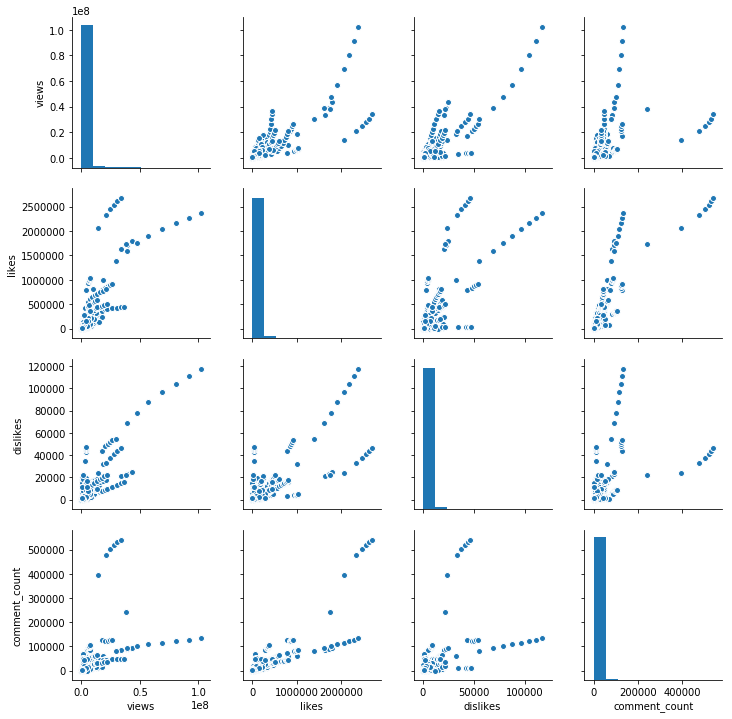

In [79]:
sns.pairplot(tidy[['views', 'likes', 'dislikes', 'comment_count']])

## Outlier Detection

By looking at the pairplots above we can see that there are some outliers Let's use a basic linear model to see if we can detected outliers

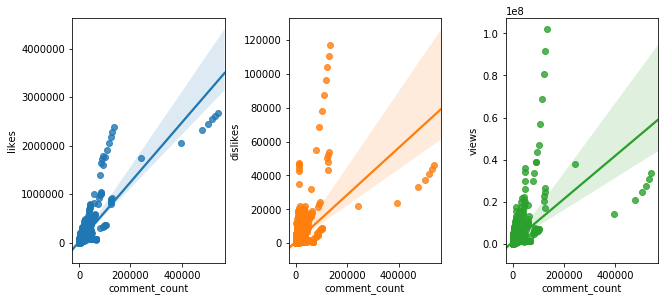

In [80]:
fig, ax = plt.subplots(1, 3)
fig.tight_layout()
plt.subplots_adjust(left=-0.4)
lplot = sns.regplot(data=tidy, x='comment_count', y='likes', ax=ax[0])
#lplot.set(xticks=[])
lplot2 = sns.regplot(data=tidy, x='comment_count', y='dislikes', ax=ax[1])
#lplot2.set(xticks=[])
lplot3 = sns.regplot(data=tidy, x='comment_count', y='views', ax=ax[2])

As you can see from the plot there are few videos that have a huge amount of comments and likes/dislikes, let's remove those outliers and replot

Remove outliers that are more than 3 std from the mean

In [81]:
outliers = tidy[(np.abs(scipy.stats.zscore(tidy[['comment_count', 'views', 'likes', 'dislikes']])) > 3).all(axis=1)]
tidy = tidy[(np.abs(scipy.stats.zscore(tidy[['comment_count', 'views', 'likes', 'dislikes']])) < 3).all(axis=1)] 

[[]]

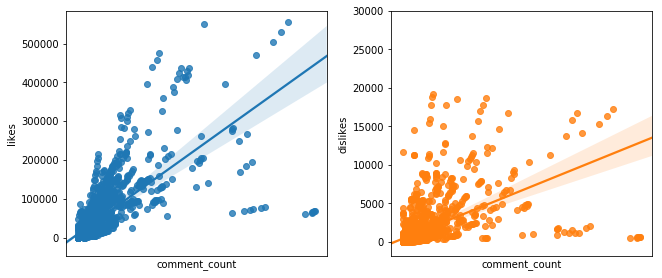

In [82]:
fig, ax = plt.subplots(1, 2, sharex=True)
fig.tight_layout()
plt.subplots_adjust(left=-0.4)
lplot = sns.regplot(data=tidy, x='comment_count', y='likes', ax=ax[0])
lplot.set(xticks=[])
lplot2 = sns.regplot(data=tidy, x='comment_count', y='dislikes', ax=ax[1])
lplot2.set(xticks=[])

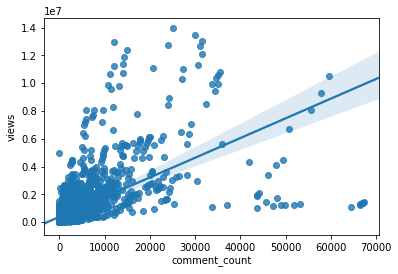

In [83]:
sns.regplot(data=tidy, x='comment_count', y='views')

Now the data looks "better" without the outliers. Let's save the preprocessed data to disk

In [84]:
tidy.to_csv('tidy_usvideos.csv')

### Let's analyze the video categories

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

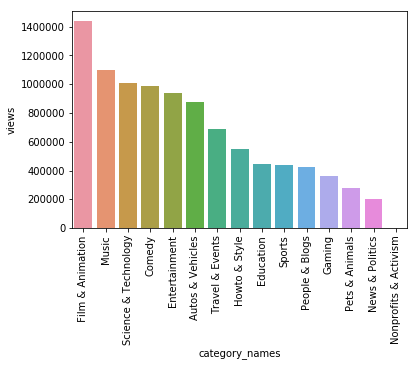

In [85]:
byviews = tidy.groupby('category_names').mean().reset_index().sort_values('views', ascending=False)
sns.barplot(data=byviews, x='category_names', y='views', ci=None)
plt.xticks(rotation=90)

Seems like film & animation, music, and science and technology get the most views, while politics and news get the least. We can get the same plots for likes and dislikes for each category.

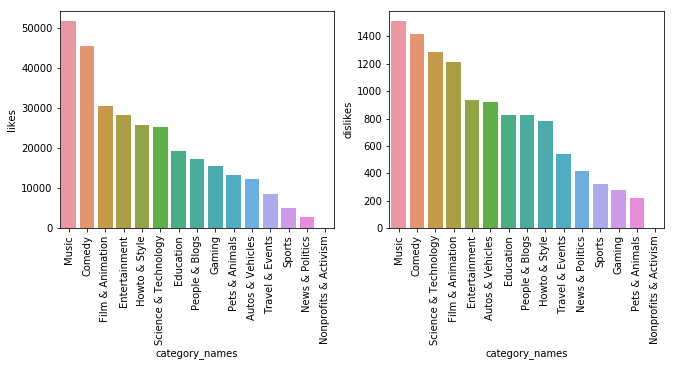

In [86]:
figs, ax = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(left=-0.5)


bylikes = tidy.groupby('category_names').mean().reset_index().sort_values('likes', ascending=False)
sns.barplot(data=bylikes, x='category_names', y='likes', ci=None, ax=ax[0])
bydislikes = tidy.groupby('category_names').mean().reset_index().sort_values('dislikes', ascending=False)
sns.barplot(data=bydislikes, x='category_names', y='dislikes', ci=None, ax=ax[1])

for axes in figs.axes:
    plt.sca(axes)
    plt.xticks(rotation=90)

We see that likes and dislikes are on par with each other. Let's see which categories get the most comments from viewers. This could give us insight into what category of videos the viewers like to show expression (by leaving comments).

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

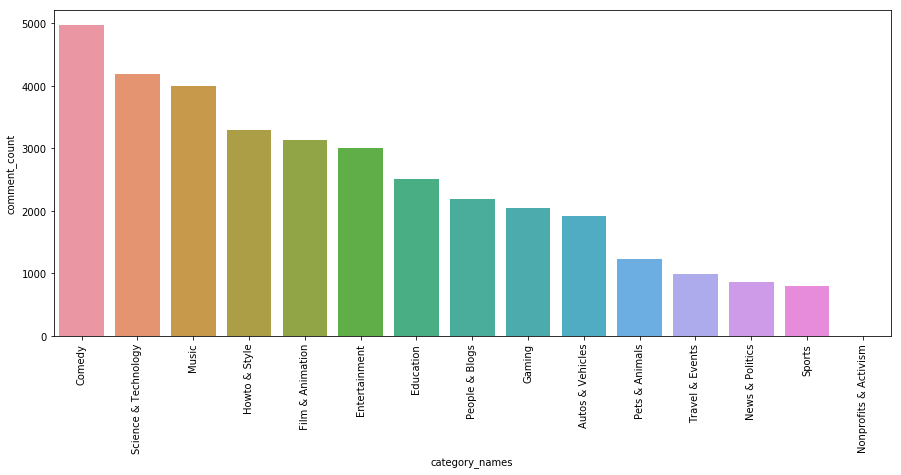

In [87]:
plt.figure(figsize=(15, 6))
bycomment = tidy.groupby('category_names').mean().reset_index().sort_values('comment_count', ascending=False)
sns.barplot(data=bycomment, x='category_names', y='comment_count', ci=None)
plt.xticks(rotation=90)

Let's get a sense of what time did the users like tp uoload their videos.

/home/anderson/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

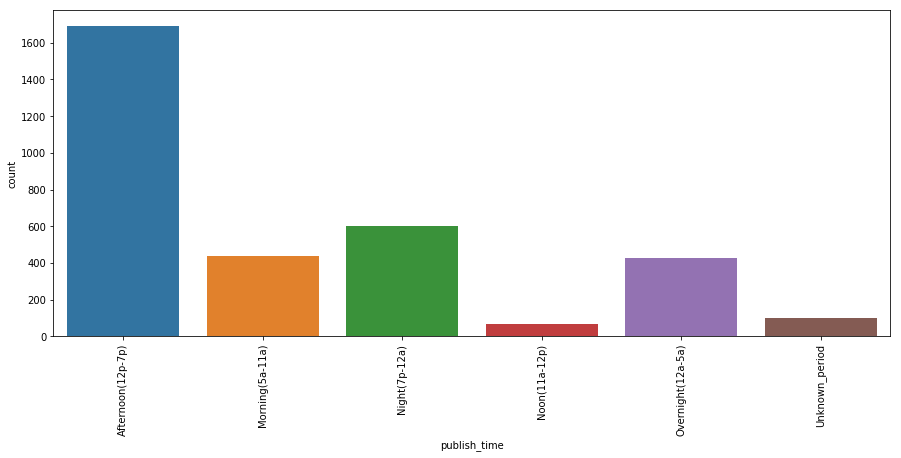

In [88]:
plt.figure(figsize=(15, 6))
sns.countplot(x='publish_time', data=tidy)
plt.legend(loc='upper right')
plt.xticks(rotation=90)

Seems like most of the videos seem to be uploaded in the afternoon. Now, we can see the count for each video category.

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

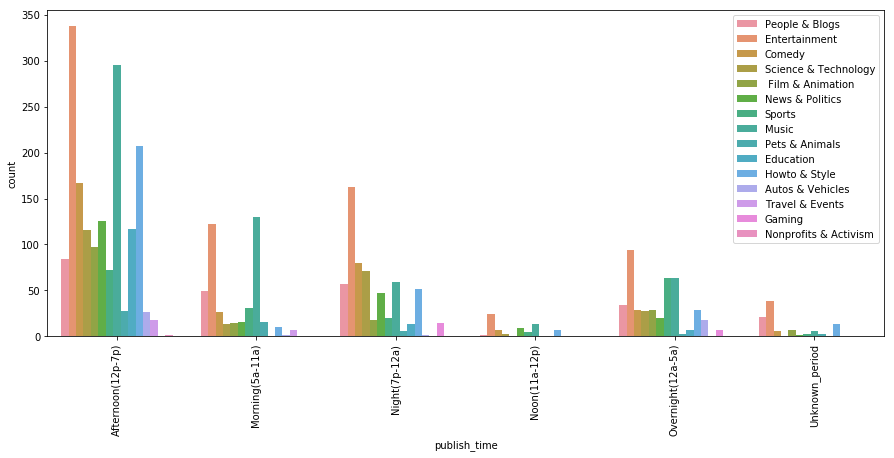

In [89]:
plt.figure(figsize=(15, 6))
sns.countplot(x='publish_time', data=tidy, hue='category_names')
plt.legend(loc='upper right')
plt.xticks(rotation=90)

So far we have seen that uploading videos in the afternoon (12pm-7pm) seems to be a common trend. The most viewed topics are Film & animations, Music, Comedy, Entertainment, and Autos & Vehicles are the most viewed and liked. Although they are also the most dislikes, the ration of likes to dislikes is huge.

# Modelling

To model the data we are going to apply a one class Support Vector Machine hoping to discriminate the data from non trending videos.ing outside as  Think of it as creating a boundary around the data, and treating everything outside the boundary as outliers and negative examples. The dataset consist of positive (trending examples only). The only features we will use is the comment_count, views, likes, dislikes.

In [90]:
from sklearn import svm
from sklearn import metrics

We will use a get_data function to get our values for the model and normalize each column

In [91]:
def get_data(df):
    vals = ['views', 'likes', 'comment_count', 'dislikes']
    df_x = df[vals]
    # df_x = (df_x[vals[:-1]] - df_x[vals[:-1]].min())/(df_x[vals[:-1]].max() - df_x[vals[:-1]].min())
    df_y = np.ones(len(df_x))
    return df_x, df_y

We will separate the data into train and test. But we will also use a whole different dataset to do additional testing. We will be testing on the trending videos from france, germany, and canada dataset.

In [92]:
france_trending = pd.read_csv('data/FRvideos.csv')
germany_trending = pd.read_csv('data/DEvideos.csv')
canada_trending = pd.read_csv('data/CAvideos.csv')

canada_x, canada_y = get_data(canada_trending)
germany_x, germany_y = get_data(germany_trending)
france_x, france_y = get_data(france_trending)
train, y = get_data(tidy)
# p = int(len(all_data) * .70)
# train = all_data[:p]
# test = all_data[p:]
# train_y = np.ones(len(train))
# test_y = np.ones(len(test))

The parameters of the OneClass svm is nu, which controls how much error we allow the classifier to make, we'll set it to 0.05 for now

In [93]:
nu = 0.03

train the classifier

In [94]:
model = svm.OneClassSVM(kernel='linear', nu=nu)
model.fit(train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.03, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [95]:
train_predict = model.predict(train)
france_predict = model.predict(france_x)
canada_predict = model.predict(canada_x)
germany_predict = model.predict(germany_x)

In [96]:
def print_scores(name, predicted, true):
    print("{0} accuracy: ".format(name), metrics.accuracy_score(true, predicted))
#     print("{0} precision: ".format(name), metrics.precision_score(true, predicted))
#     print("{0} recall: ".format(name), metrics.recall_score(true, predicted))
#     print("{0} f1_score: ".format(name), metrics.f1_score(true, predicted))
    print()

Below we can see the performance of the one class svm

In [97]:
print_scores("us trending", y, train_predict)
print_scores("france trending", france_y, france_predict)
print_scores("canada trending ", canada_y, canada_predict)
print_scores("germany trending", germany_y, germany_predict)

us trending accuracy:  0.970261339742

france trending accuracy:  0.867863449088

canada trending  accuracy:  0.992642731018

germany trending accuracy:  0.922330097087



By using a one class linear svm we are able to predict what videos will trend or not with high accuracy.